In [1]:
import os
os.chdir('/Users/anthony/git-projects/midas')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from research.backtesting import BacktestLogger, FuturesBacktest, HTMLReportGenerator
from research.data_analysis import DataProcessing, TimeseriesTests
from research.strategies.cointegrationzscore.logic import Cointegrationzscore
from engine.core.base.data import Symbol, Equity, Future, Currency, Exchange
import logging


In [2]:
# Step 1 : Set data parameters
start_date = "2018-05-18"
end_date = "2023-01-19"

symbols = [
            Future(ticker="HE.n.0",currency=Currency.USD,exchange=Exchange.SMART, fees=0.85, lastTradeDateOrContractMonth="continuous",contractSize=50,tickSize=0.25, initialMargin=4564.17),
            Future(ticker="ZC.n.0",currency=Currency.USD,exchange=Exchange.CME,fees=0.85,lastTradeDateOrContractMonth="continuous",contractSize=50,tickSize=0.25, initialMargin=2056.75)
        ]

symbols_map = {symbol.ticker: symbol for symbol in symbols}
print(symbols_map)


{'HE.n.0': Future(ticker='HE.n.0', secType=<SecType.FUTURE: 'FUT'>, currency=<Currency.USD: 'USD'>, exchange=<Exchange.SMART: 'SMART'>, fees=0.85, contract=4547209024: 53707317174992757629794062988810589205,HE.n.0,FUT,continuous,0.0,,,SMART,,USD,,,False,,combo:, lastTradeDateOrContractMonth='continuous', contractSize=50, tickSize=0.25, initialMargin=4564.17), 'ZC.n.0': Future(ticker='ZC.n.0', secType=<SecType.FUTURE: 'FUT'>, currency=<Currency.USD: 'USD'>, exchange=<Exchange.CME: 'CME'>, fees=0.85, contract=4547211280: 117279502596286025818338407221345265655,ZC.n.0,FUT,continuous,0.0,,,CME,,USD,,,False,,combo:, lastTradeDateOrContractMonth='continuous', contractSize=50, tickSize=0.25, initialMargin=2056.75)}


In [3]:
# Step 2 : Retrieve Data
data_processing = DataProcessing()
data = data_processing.get_data(list(symbols_map.keys()), start_date,end_date)


There are missing values in the DataFrame:
symbol                     HE.n.0  ZC.n.0
timestamp                                
2018-08-05 00:00:00+00:00     NaN  384.25


In [4]:
## Step 3 : Data preparation
data = data.ffill()
data_processing.check_missing(data)
# log_data = np.log(data)


No missing values in the DataFrame.


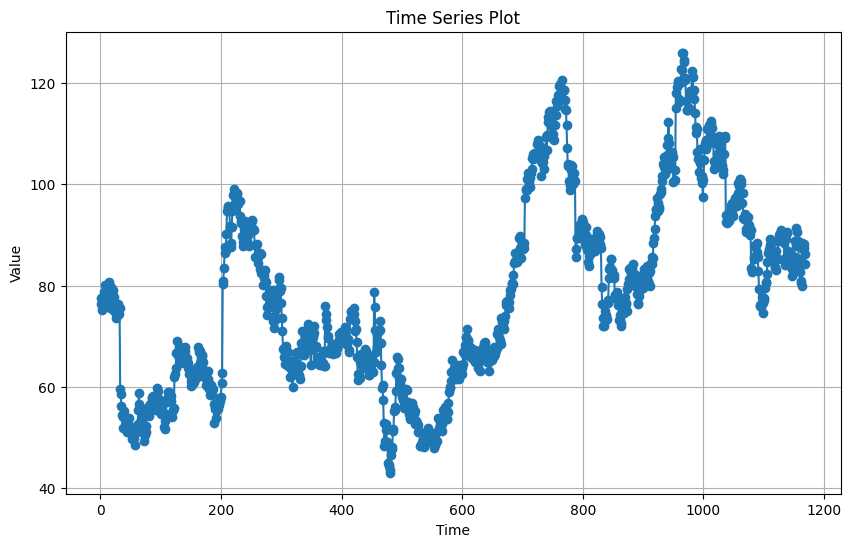

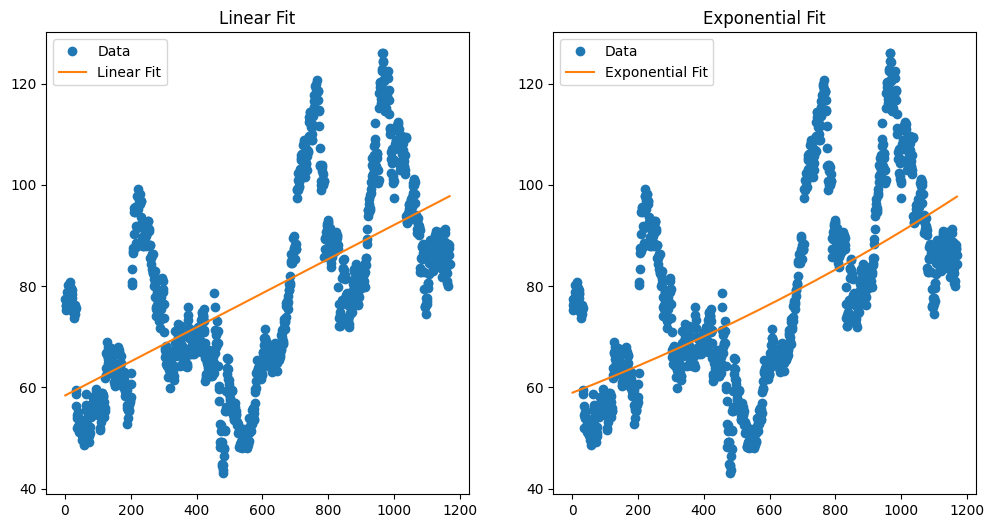

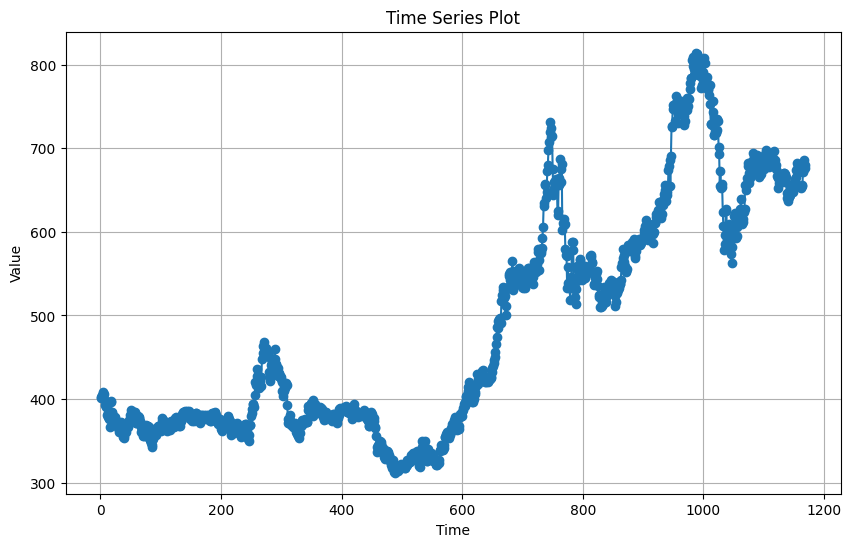

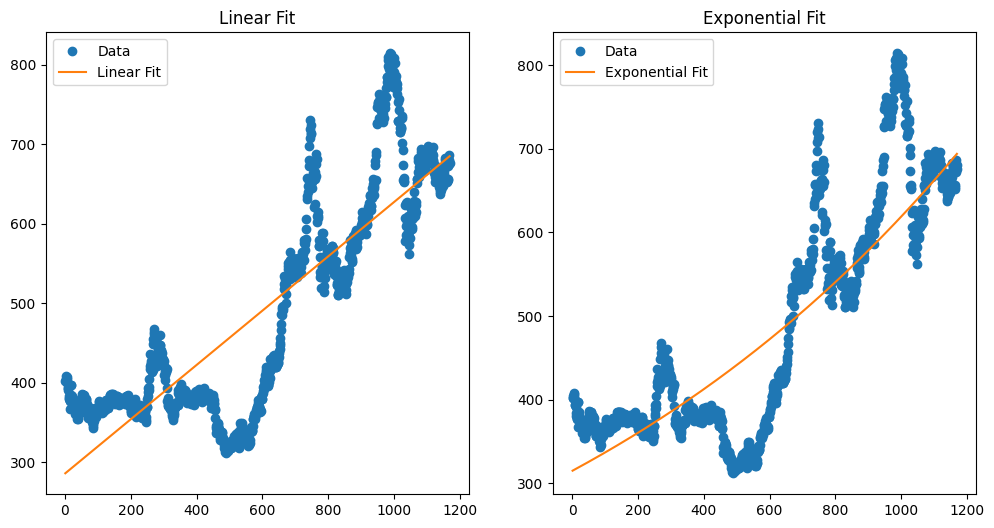

Breusch Pagan Results:
                   Ticker  Breusch-Pagan Test Statistic   p-value Heteroscedasticity
0  HE.n.0_linear_residual                     21.980127  0.000003            Present
1     HE.n.0_exp_residual                      0.005446  0.941172             Absent
2  ZC.n.0_linear_residual                    300.178396  0.000000            Present
3     ZC.n.0_exp_residual                      1.885005  0.169766             Absent
** IF p-value < 0.05, then REJECT the Null Hypothesis of homoscedasticity (constant variance) in favor of heteroscedasticity (varying variance).



In [5]:
## Step 3 : Test for exponential nature (determine if log prices will be used)
time_array = range(1, len(data) + 1)
bp_results = {}

for column in data.columns:
    value_array = data[column].values
    TimeseriesTests.line_plot(x=time_array, y=value_array)

    residuals_linear, residuals_exp = data_processing.fit_and_compare(time_array, value_array)

    bp_results[f"{column}_linear_residual"] = TimeseriesTests.breusch_pagan(np.array(residuals_linear), np.array(time_array))
    constant_to_add = abs(residuals_exp.min()) + 1

    # Adjust residuals and apply log transformation
    adjusted_residuals_exp = np.log(np.abs(residuals_exp) + constant_to_add)

    # Perform Breusch-Pagan test on adjusted residuals
    bp_results[f"{column}_exp_residual"] = TimeseriesTests.breusch_pagan(np.array(time_array), np.array(adjusted_residuals_exp))


TimeseriesTests.display_breusch_pagan_results(bp_results)



In [6]:
## Step 4 : Check stationarity
adf_results = {}
kpss_results = {}
pp_results = {}


for column in data.columns:
    series = data[column]
    adf_results[column] = TimeseriesTests.adf_test(series, trend='ct')
    pp_results[column] = TimeseriesTests.phillips_perron_test(series, trend='ct')
    # kpss_results[column] = TimeseriesTests.kpss_test(series, trend='ct')

TimeseriesTests.display_adf_results(adf_results)
TimeseriesTests.display_pp_results(pp_results)
# TimeseriesTests.display_kpss_results(kpss_results)



ADF Test Results:
                       Ticker  ADF Statistic   p-value  Critical Value (1%)  Critical Value (5%)  Critical Value (10%)    Stationarity
0  HE.n.0      -2.664168  0.251259            -3.966549            -3.414259             -3.129268  Non-Stationary
1  ZC.n.0      -2.942952  0.148735            -3.966698            -3.414331             -3.129311  Non-Stationary
                    ** IF p-value < 0.05 and/or statistic < statistic @ confidence interval, then REJECT the Null that the time series posses a unit root (non-stationary).

                

Phillips Perron Results:
                       Ticker  PP Statistic   p-value  Critical Value (1%%)  Critical Value (5%%)  Critical Value (10%%)    Stationarity
0  HE.n.0     -2.756582  0.213348             -3.966542             -3.414256              -3.129267  Non-Stationary
1  ZC.n.0     -2.532524  0.311897             -3.966542             -3.414256              -3.129267  Non-Stationary
                    ** IF p-v

In [7]:
## Step 5 : Check stationarity at first difference
adf_results_diff = {}
kpss_results_diff = {}
pp_results_diff = {}

for column in data.columns:
    series = data[column].diff(1)
    series.dropna(inplace=True)
    adf_results_diff[f"{column}_diff"] = TimeseriesTests.adf_test(series)
    pp_results_diff[f"{column}_diff"] = TimeseriesTests.phillips_perron_test(series, trend='ct')
    # kpss_results_diff[f"{column}_diff"] = TimeseriesTests.kpss_test(series)

TimeseriesTests.display_adf_results(adf_results_diff)
TimeseriesTests.display_pp_results(pp_results_diff)
# TimeseriesTests.display_kpss_results(kpss_results_diff)


ADF Test Results:
                            Ticker  ADF Statistic   p-value  Critical Value (1%)  Critical Value (5%)  Critical Value (10%) Stationarity
0  HE.n.0_diff     -32.672131  0.000000            -3.435966            -2.864020             -2.568090   Stationary
1  ZC.n.0_diff      -5.605242  0.000001            -3.436074            -2.864068             -2.568116   Stationary
                    ** IF p-value < 0.05 and/or statistic < statistic @ confidence interval, then REJECT the Null that the time series posses a unit root (non-stationary).

                

Phillips Perron Results:
                            Ticker  PP Statistic  p-value  Critical Value (1%%)  Critical Value (5%%)  Critical Value (10%%) Stationarity
0  HE.n.0_diff    -32.639404      0.0             -3.966549             -3.414259              -3.129268   Stationary
1  ZC.n.0_diff    -35.114203      0.0             -3.966549             -3.414259              -3.129268   Stationary
                    

In [8]:
## Step 6 : Check seasonality
seasonal_adf_results = {}

for column in data.columns:
    series = data[column]
    seasonal_adf_results[f"{column}_seasonality"] = TimeseriesTests.seasonal_adf_test(series)

TimeseriesTests.display_adf_results(seasonal_adf_results)


ADF Test Results:
                                   Ticker  ADF Statistic  p-value  Critical Value (1%)  Critical Value (5%)  Critical Value (10%) Stationarity
0  HE.n.0_seasonality     -12.007404      0.0            -3.436114            -2.864085             -2.568125   Stationary
1  ZC.n.0_seasonality     -10.134599      0.0            -3.436130            -2.864092             -2.568129   Stationary
                    ** IF p-value < 0.05 and/or statistic < statistic @ confidence interval, then REJECT the Null that the time series posses a unit root (non-stationary).

                


In [9]:
## Step 7 : Check granger causality (Use differenced data as it needs to be stationary)
data_diff = data.diff(1).dropna()
granger_results = TimeseriesTests.granger_causality(data_diff, max_lag=4)
TimeseriesTests.display_granger_results(granger_results)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1122  , p=0.7377  , df_denom=1164, df_num=1
ssr based chi2 test:   chi2=0.1125  , p=0.7373  , df=1
likelihood ratio test: chi2=0.1125  , p=0.7373  , df=1
parameter F test:         F=0.1122  , p=0.7377  , df_denom=1164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1005  , p=0.9044  , df_denom=1161, df_num=2
ssr based chi2 test:   chi2=0.2019  , p=0.9040  , df=2
likelihood ratio test: chi2=0.2019  , p=0.9040  , df=2
parameter F test:         F=0.1005  , p=0.9044  , df_denom=1161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2130  , p=0.8874  , df_denom=1158, df_num=3
ssr based chi2 test:   chi2=0.6429  , p=0.8866  , df=3
likelihood ratio test: chi2=0.6427  , p=0.8866  , df=3
parameter F test:         F=0.2130  , p=0.8874  , df_denom=1158, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5011  , p=0.

/Users/anthony/git-projects/midas/research/data_analysis/timeseries_analysis.py:866: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = model.params[-1]  # Get the AR coefficient (last parameter)


1169
1169


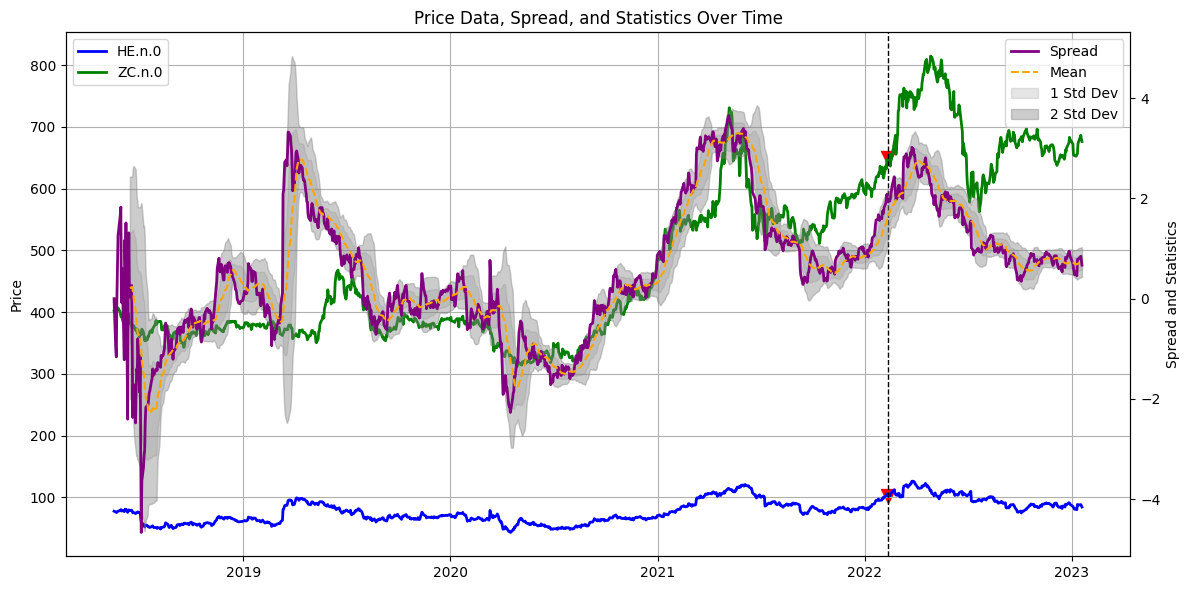

1169
1169


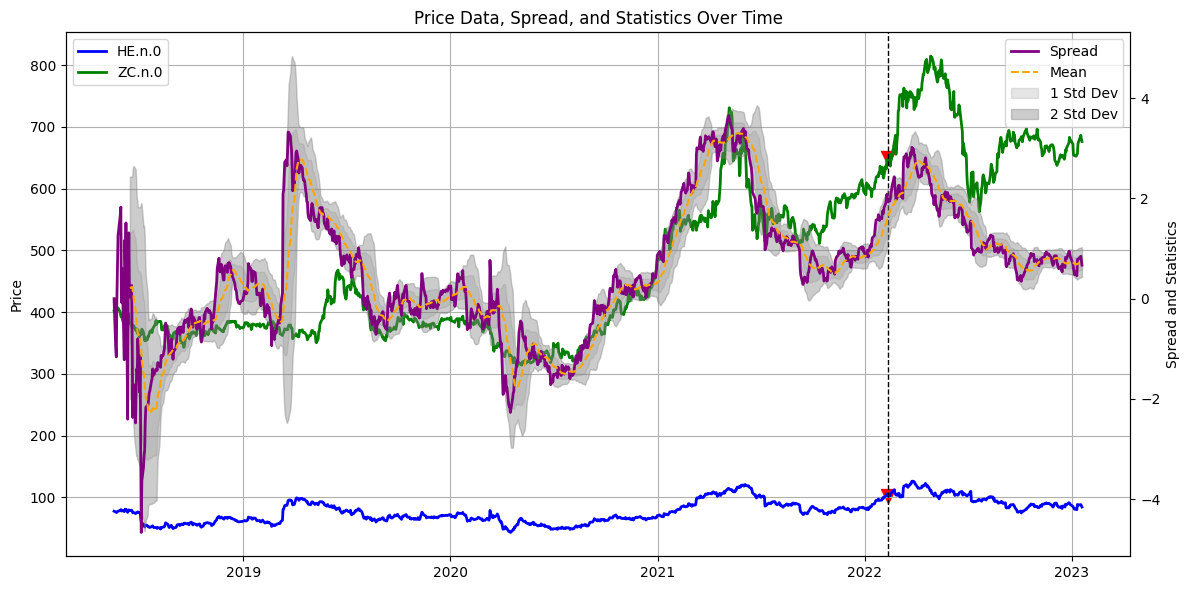

In [10]:

strategy_name = "cointegrationzscore"

# Instantiate the BacktestLogger
logger = BacktestLogger(strategy_name).logger

# Report Generator
report_generator = HTMLReportGenerator(strategy_name)

# Strategy
strategy = Cointegrationzscore(symbols_map,logger, report_generator)

# Backtest
backtest = FuturesBacktest(strategy, symbols_map, full_data=data, trade_allocation=0.20, logger=logger, report_generator=report_generator)

# Parameters to be sensitized 
entry_thresholds = np.arange(0.5, 1.5, 0.5)  # Example range for entry
exit_thresholds = np.arange(0.5, 2.5, 0.5)  # Example range for exit

# Walk forward-analysis
backtest.walk_forward_analysis(total_segments=1, entry_thresholds=entry_thresholds, exit_thresholds=[0.0])
report_generator.complete_report()


In [11]:
# jupyter nbconvert --to pdf 'core/strategies/commodity_cointegration/research.ipynb'

